# Gaussian processes

Suppose we want to model a function $f$

A function can be also represented as a list of (potentially infinite) pairs $(x_i, y_i)$.

We can let each $y_i$ be a Gaussian random variable.

In this way, we can represent a family of distributions of functions, in a probabilistic way

But, in real world we cannot have infinite pairs

The trick, approximate by using only the data point available

A Gaussian process is:

<i>"The collection of random variables indexed by time or space, such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed."</i>

Therefore we can express a GP by a vector of mean (usually 0s) and a covariance matrix between the points.

The key element, is the *covariance matrix*, that is usually specified by a **kernel function**

# Kernel Functions

A **kernel** is a symmetric function that takes two inputs and returns:
- zero if the inputs are the same
- positive otherwise

In other words, we can interpret the output of a kernel function $\phi$ as a measure of similarity between two inputs.

Specifically in a Gaussian Process (GP), a kernel function $\phi$ describes the covariance matrix (or _kernel matrix_) of a multivariate Gaussian distribution.

Let $\mathcal{X} = \{x_1,\ldots,x_n\}$ a set of data points.
The covariance matrix $K(x,x') \in \mathbb{R}^{n\times n}$ induced by $\phi$ is defined as follows.

$$K(x,x')=\begin{bmatrix}
\phi(x_1,x_1) & \ldots & \phi(x_1,x_n) \\
\vdots & \ddots & \vdots \\
\phi(x_n,x_1) & \ldots & \phi(x_n,x_n)
\end{bmatrix}$$

In order to be valid, a kernel function must induce a covariance matrix $K(x,x')$ which is **positive-definite**, i.e. symmetric and satisfying the following proposition.

$$\forall x\in\mathbb{R}^n \quad x^T K(x,x') x > 0$$

This property on the covariance matrix also ensures that it is invertible, which is an important requirement for computing the likelihood of a multivariate Gaussian distribution.

Kernel functions are also used in other models, such as Support Vector Machines (SVM).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


def covariance_matrix(x, kf, **kwargs):
    x1 = np.expand_dims(x, axis=0)
    x2 = np.expand_dims(x, axis=1)
    return kf(x1, x2, **kwargs)


def gp_sample(kf, xmin=-4.0, xmax=4.0, n_samples=150, **kwargs):
    x = np.linspace(xmin, xmax, n_samples)
    m = np.zeros(n_samples)
    k = covariance_matrix(x, kf, **kwargs)
    y = np.random.multivariate_normal(mean=m, cov=k)
    return x, y, k


def plot_gp_sample(name, kf, kwargs_ls, n_functions=3):
    ls_kwargs = [dict(zip(kwargs_ls, v)) for v in zip(*kwargs_ls.values())]
    fig, axs = plt.subplots(nrows=len(ls_kwargs), ncols=2, figsize=(12, 3.5 * len(ls_kwargs)))
    for i, kwargs in enumerate(ls_kwargs):
        axs[i, 0].set_title('{} {}'.format(name, kwargs))
        for k in range(n_functions):
            x, y, k = gp_sample(kf, **kwargs)
            axs[i, 0].plot(x, y)
        axs[i, 1].xaxis.tick_top()
        axs[i, 1].set_xticks([0, len(k) - 1], labels=[0, '{}'.format(len(k))])
        axs[i, 1].set_yticks([0, len(k) - 1], labels=[0, '{}'.format(len(k))])
        axs[i, 1].invert_yaxis()
        im = axs[i, 1].imshow(k, interpolation='antialiased')
        plt.colorbar(im, ax=axs[i, 1])
    fig.tight_layout()

### Exponential Quadratic Kernel

$$\phi(x,x') = \exp \left( -\frac{(x-x')^2}{2\ell^2} \right)$$
where $\ell > 0$ is the _length-scale_.

- Higher values for $\ell$ will make the sampled functions _smoother_
- Lower values for it will make the sampled functions _noiser_.

Also, with lower values for $\ell$, the induced covariance matrix will be more similar to an identity matrix, hence having full independence between random variables (points).

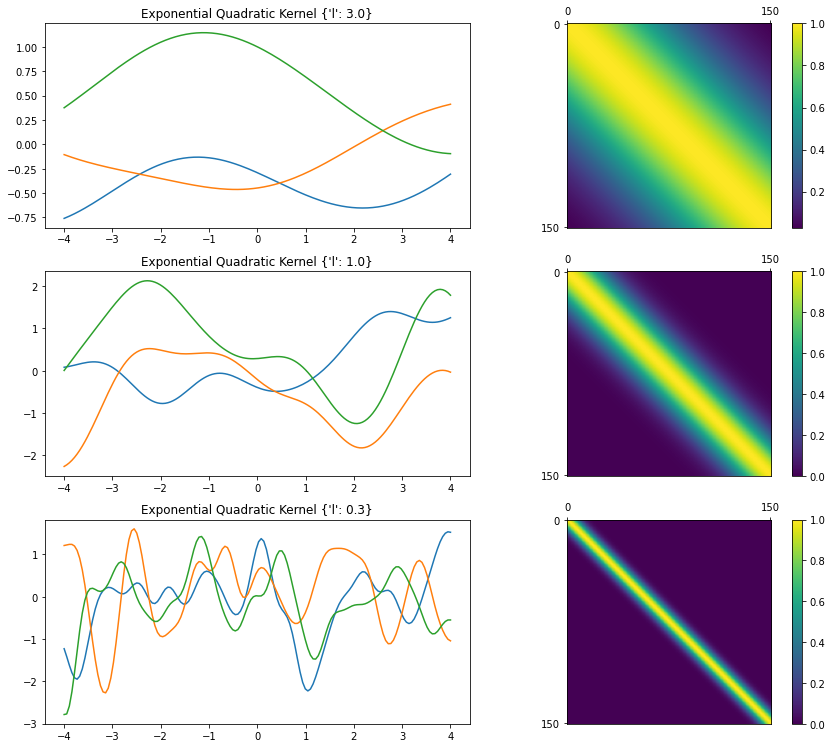

In [2]:
def kernel_expquad(x1, x2, l): return np.exp(-((x1 - x2) ** 2.0) / (2 * l ** 2.0))
plot_gp_sample("Exponential Quadratic Kernel", kernel_expquad, kwargs_ls={'l': [3.0, 1.0, 0.3]})

### Linear Kernel

$$\phi(x,x') = (x-c)(x'-c)$$
where $c\in\mathbb{R}$ is the _intercept_ parameter.

The _intercept_ parameter $c$ controls the crossing point of all the linear functions sampled by the Gaussian Process.

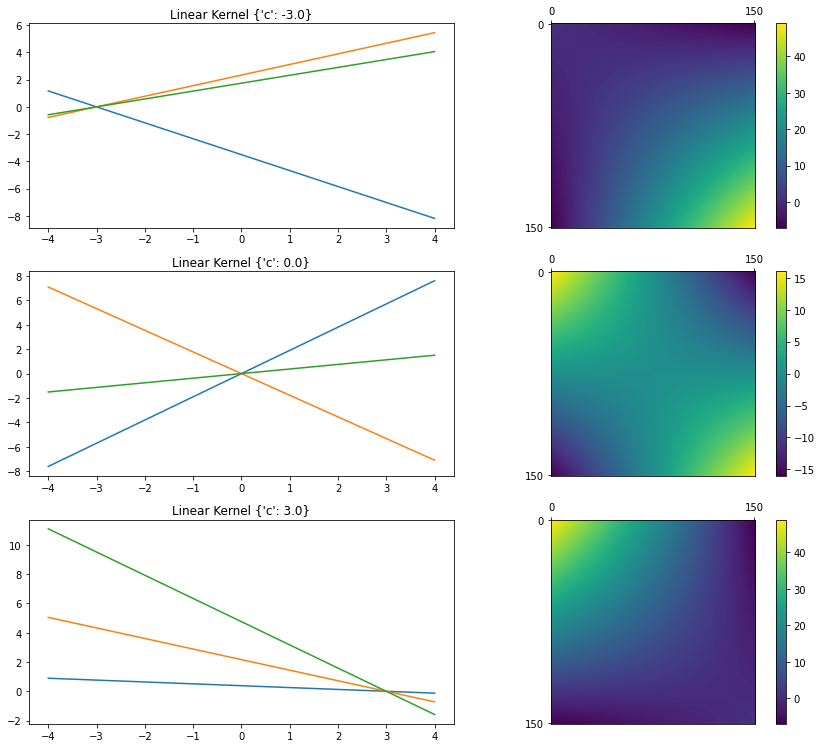

In [3]:
def kernel_linear(x1, x2, c): return (x1 - c) * (x2 - c)
plot_gp_sample("Linear Kernel", kernel_linear, kwargs_ls={'c': [-3.0, 0.0, 3.0]})

### Periodic Kernel

$$\phi(x,x') = \exp \left( -\frac{2}{\ell^2} \sin^2 \left( \frac{\pi|x-x'|}{p} \right) \right)$$

- $\ell > 0$ is the _length-scale_
- $p>0$ is the _period_ (the distance between repetitions of the function).

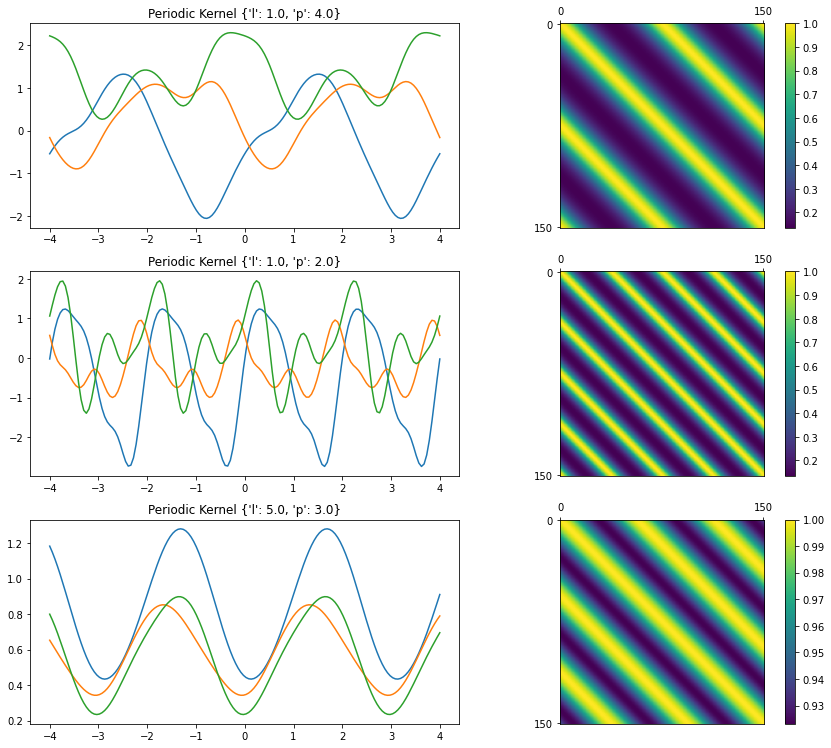

In [4]:
def kernel_periodic(x1, x2, l, p): return np.exp(-2.0 / (l ** 2.0) * np.sin(np.pi * np.abs(x1 - x2) / p) ** 2.0)
plot_gp_sample("Periodic Kernel", kernel_periodic, kwargs_ls={'l': [1.0, 1.0, 5.0], 'p': [4.0, 2.0, 3.0]})

### Combining Kernel Functions

Positive-definite kernel functions (like the ones we just seen) can be **composed** together using a linear combination (alternatively, a multiplication).

Using non-negative weights will always induce a positive-definite kernel 
$$\phi(x,x') = \sum_{i=1}^n \lambda_i \phi_i(x,x')$$
where each $\phi_i$ is a positive-definite kernel function, and each $\lambda_i$ is a non-negative weight.

An example of compositive kernel function is given by an _exponential quadratic_ kernel and a _periodic_ kernel.

$$\phi(x,x') = \exp \left( -\frac{(x-x')^2}{2\ell^2_1} \right) + 0.5 \exp \left( -\frac{2}{\ell^2_2} \sin^2 \left( \frac{\pi|x-x'|}{p} \right) \right)$$

The advantage of this is the capability of modeling very complex interactions between data points.

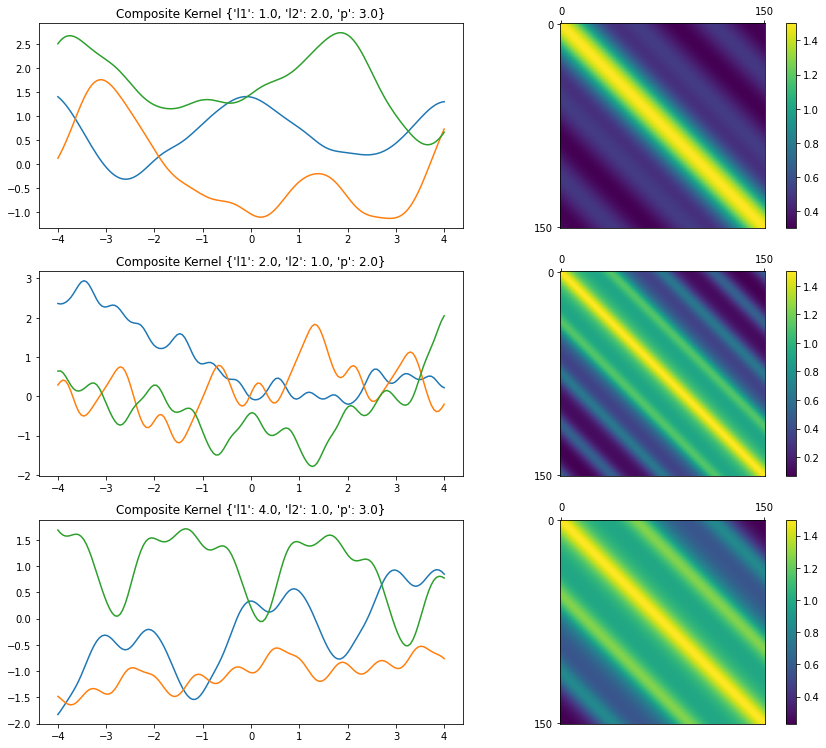

In [5]:
def kernel_composite(x1, x2, l1, l2, p): return kernel_expquad(x1, x2, l1) + 0.5 * kernel_periodic(x1, x2, l2, p)
plot_gp_sample("Composite Kernel", kernel_composite, kwargs_ls={'l1': [1.0, 2.0, 4.0], 'l2': [2.0, 1.0, 1.0], 'p': [3.0, 2.0, 3.0]})

# Gaussian Process Regression

In [6]:
import pymc3 as pm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let's assume we can model a value $y$ as a function $f$ of $x$ plus some noise:
$$
y \sim \mathcal{N}(\mu = f(x), \sigma = \epsilon)$$
We use a GP as a prior of $f$
$$
f(x) \sim \mathcal{GP}(\mu_x, K(x, x'))
$$

Let's try it to fit the sinus function

Text(0, 0.5, 'f(x)')

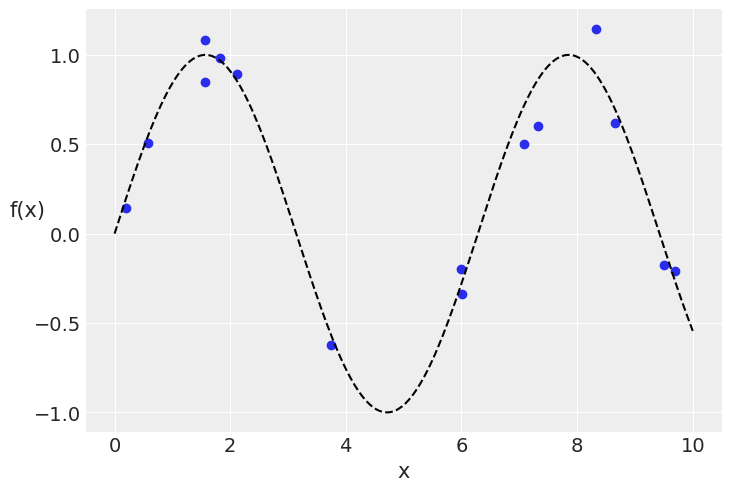

In [7]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

In [10]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    l = pm.Gamma('l', 2, 0.5)
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    eps = pm.HalfNormal('eps', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=eps)

The marginal likelihood is the integral of the likelihood and the prior;

For a GP prior $p(f\mid X,\theta)$ and a Gaussian likelihood $p(y\mid f,X,\theta)$, the following marginalization can be performed analytically (i.e. it is _mathematically tractable_).

$$p(y\mid X,\theta) \sim \int p(y\mid f,X,\theta) p(f\mid X,\theta)\ df$$

In [11]:
with model_reg:
    trace_reg = pm.sample(
        chains=2, draws=1000, tune=500, cores=1,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, l]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Now, we can sample function for new point $X_*$ by *conditioning* the distribution.

Let:

$$
K = K(X, X) \\
K_* = K(X, X^*) \\
K_{**} = K(X^*, X^*)
$$

then:

$$
p(f(X_*)|X_*, X, y) \sim \mathcal{N}(\mu, \Sigma) \\
\mu = K^*_T K^{-1} y\\
\Sigma = K_{**} - K^*_T K^{-1} K_*
$$

With PYMC3 we can use the **gp.conditional** function:

In [12]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

We get a new PyMC3 random variable, *f_pred*, that we can use to get samples from the posterior predictive distribution (evaluated at the X_new values)

In [16]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, var_names=['f_pred'],
        samples=82)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


And now we can plot some sampled fitted functions over the original data

Text(0.5, 0, 'X')

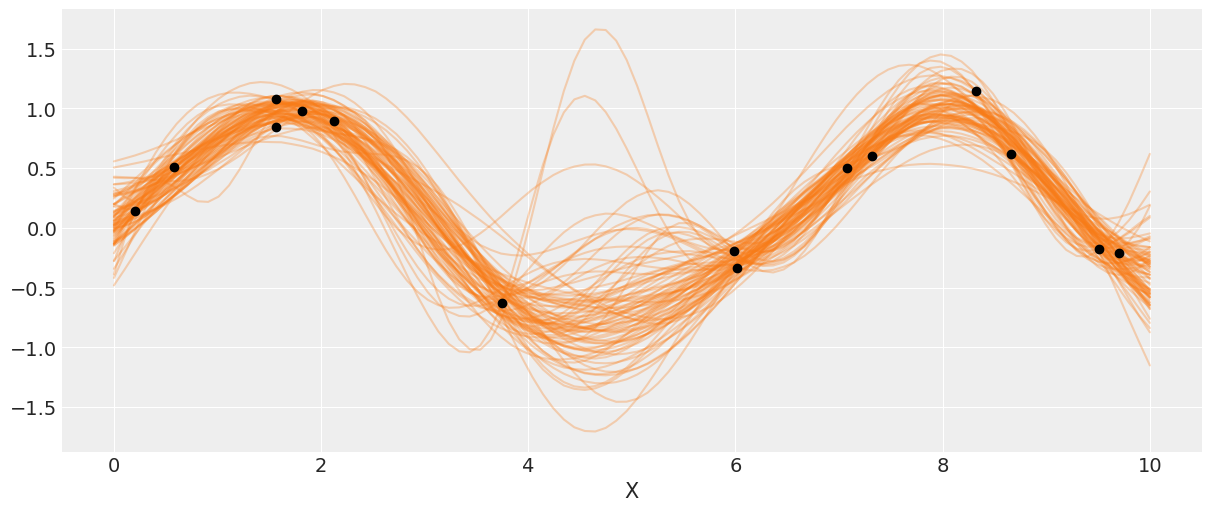

In [17]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Or we can see the percentiles ranging from 51 (lighter) to 99 (darker)

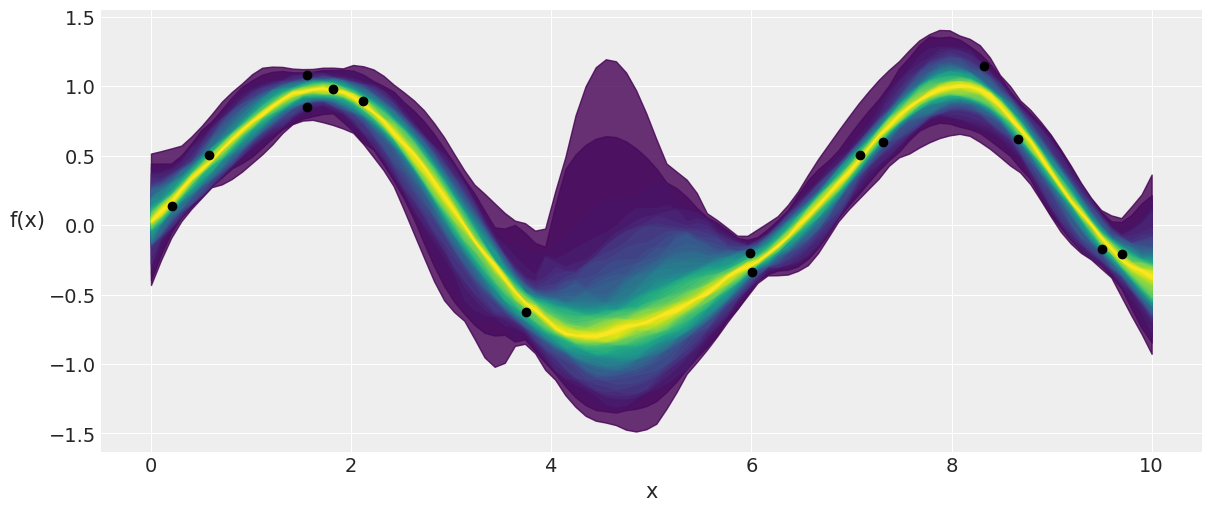

In [19]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new,
palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.show()

# Gaussian Process Classification

In Generalized Linear Models (GLM), we turn a linear model (e.g. linear regression) into a classifier modeled using a Bernoulli likelihood, which is parameterized with a **logistic** inverse link function.

The classification can then be made by applying a _boundary decision rule_ to separate classes.

In the same way, we can turn a Gaussian Process (GP) regression model to the classification setting.

This is done by using a GP as our _prior distribution_ for the parameter (in logit-space) of a Bernoulli distribution.

For a GP prior $p(f\mid X,\theta)$ and a Gaussian likelihood $p(y\mid f,X,\theta)$, the following marginalization can be performed analytically (i.e. it is _mathematically tractable_).

$$p(y\mid X,\theta) \sim \int p(y\mid f,X,\theta) p(f\mid X,\theta)\ df$$

However, in the classification setting, we do not have a Gaussian likelihood.

Therefore such marginalization can only be done approximately (e.g. using MCMC).

This will make our model slightly more complex, also from a computational point of view.

In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import theano.tensor as tt

np.random.seed(42)
az.style.use('arviz-whitegrid')

Load the Iris dataset (but only one feature and one class)

In [3]:
data = pd.read_csv('data/iris.csv')
data = data.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(data['species']).codes
x = data['sepal_length'].values
x = x[:, None]

Using PyMC3 we can build a GP _prior distribution_ easily and sample from the **posterior distribution**, even in presence of the marginalization un-tractability discussed before.

In [ ]:
# Build a PyMC3 GP classification model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter, and the GP prior
    ls = pm.Gamma('ls', 2.0, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ls) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x)

    # Use logistic inverse link function and Bernoulli likelihood
    y_pred = pm.Bernoulli('y_pred', p=tt.nnet.sigmoid(f), observed=y)

In [4]:
# Sample from posterior
with model:
    trace = pm.sample(
        chains=2, draws=4000, tune=2000, cores=1,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, ls]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 169 seconds.


C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_1936\3646448333.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


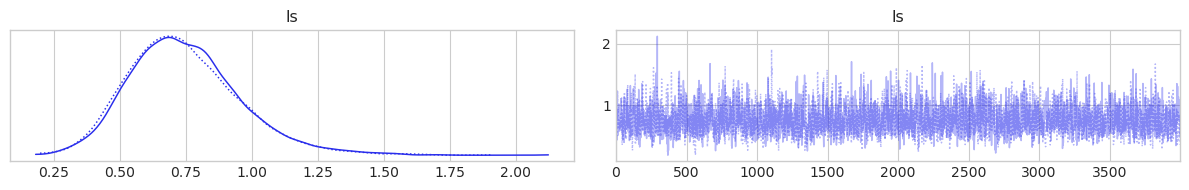

In [5]:
# Plot the traces
az.plot_trace(trace, var_names=['ls'])
plt.tight_layout()
plt.show()

Now that we have found the values of the parameter of the covariance function, 

We can get samples from the GP posterior of the functions fitting the data, by computing the **conditional distribution**

In [6]:
# Sample from the conditional distribution, over new un-observed points
x_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 200)[:, None]
with model:
    f_pred = gp.conditional('f_pred', x_new)
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['f_pred'], keep_size=True)
    pred_samples = pred_samples['f_pred'].squeeze()

In [26]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def find_midpoint(array1, array2, value):
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

We can finally plot the distribution of both the sigmoid function and the decision boundary.

In [ ]:
def plot_sigmoid_db(plot_db=True):
    fp = sigmoid(pred_samples); fp_mean = np.mean(fp, axis=(0, 1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_new.squeeze(1), fp_mean, 'C2', lw=2)
    plt.scatter(x, np.random.normal(y, 0.02), marker='.', color=[f'C{x}' for x in y])
    az.plot_hdi(x_new.squeeze(1), fp, color='C2')
    if plot_db:
        db = np.array([find_midpoint(f, x_new.squeeze(1), 0.5) for f in fp.reshape(fp.shape[0] * fp.shape[1], fp.shape[2])])
        db_mean = db.mean(); db_hdi = az.hdi(db)
        plt.vlines(db_mean, 0, 1, color='k')
        plt.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
    plt.xlabel('sepal_length'); plt.ylabel('θ', rotation=0)

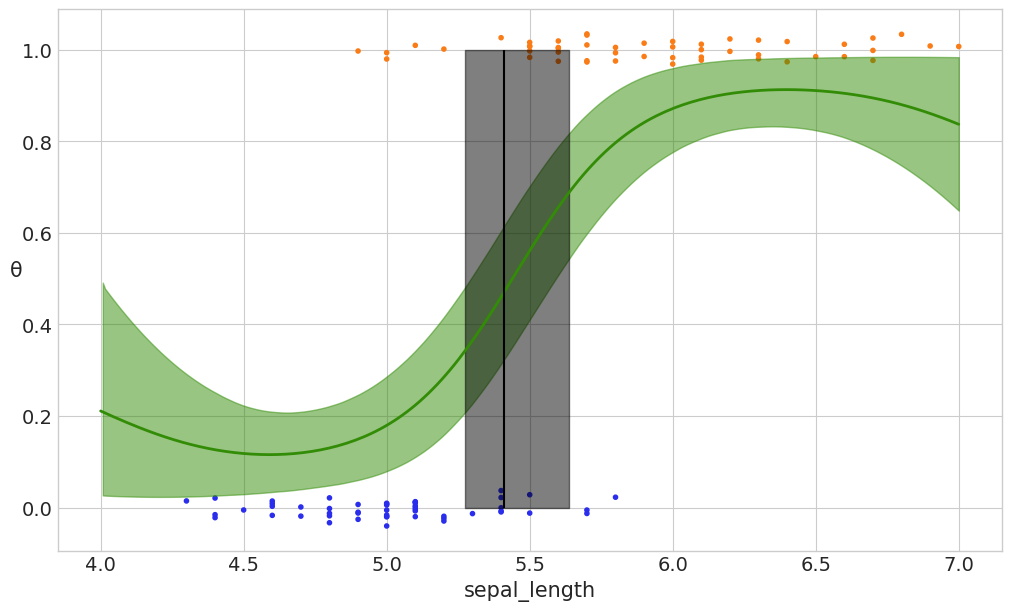

In [27]:
plot_sigmoid_db(); plt.show()

The previous picture looks like a sigmoid curve as expected.
However, the _tails_ of this function **diverge** when we step away from the decison boundary and the observed samples themselves.

This is due to the fact that we only considered an _exponential quadratic kernel_.

A general way to get better GP models is by combining more than one covariance functions in order to better capture the details of the function we are going to model.

In our case we can add a _linear kernel_ in our covariance function, with an additional weight parameter with a prior itself.

In [34]:
# Build a PyMC3 GP classification model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameters, and the GP prior
    ls = pm.Gamma('ls', 2.0, 0.5)
    c = pm.Normal('c', x.min())
    tau = pm.HalfNormal('tau', 5.0)
    cov = pm.gp.cov.ExpQuad(1, ls) + tau * pm.gp.cov.Linear(1, c) + \
        pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x)

    # Use logistic inverse link function and Bernoulli likelihood
    y_pred = pm.Bernoulli('y_pred', p=tt.nnet.sigmoid(f), observed=y)

In [37]:
# Sample from posterior
with model:
    trace = pm.sample(
        chains=2, draws=4000, tune=4000, cores=1,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, tau, c, ls]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 435 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_1936\4061771498.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


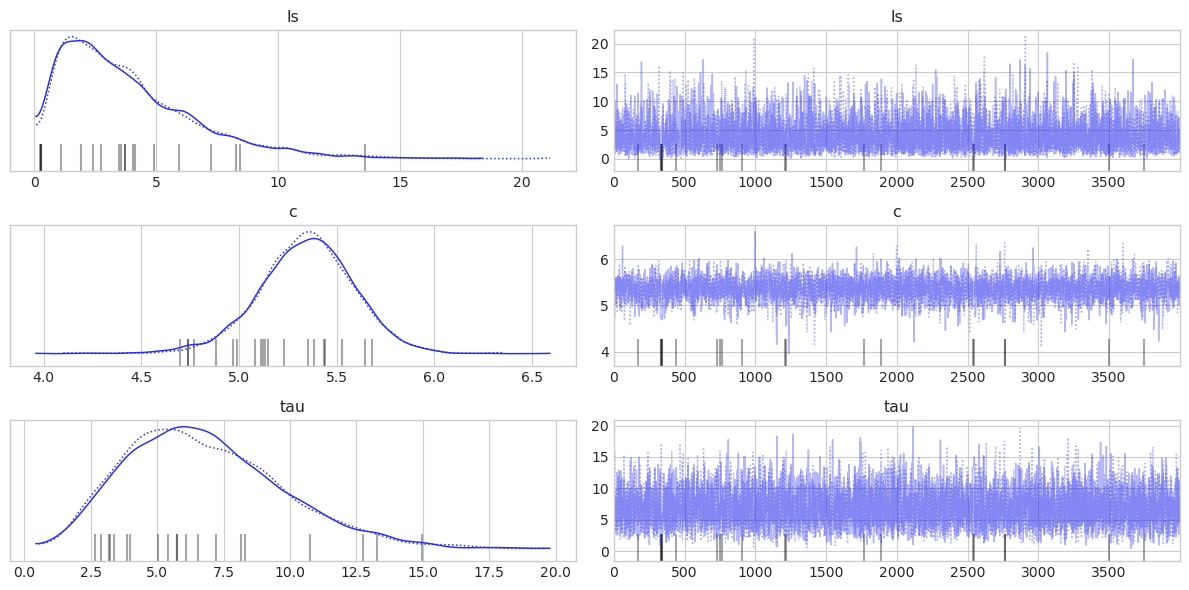

In [38]:
# Plot the traces
az.plot_trace(trace, var_names=['ls', 'c', 'tau'])
plt.tight_layout()
plt.show()

Again, we sample from the conditional distribution over new un-observed points. and then plot the distribution of both the sigmoid function and the decision boundary.

In [39]:
# Sample from the conditional distribution, over new un-observed points
x_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 200)[:, None]
with model:
    f_pred = gp.conditional('f_pred', x_new)
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['f_pred'], keep_size=True)
    pred_samples = pred_samples['f_pred'].squeeze()

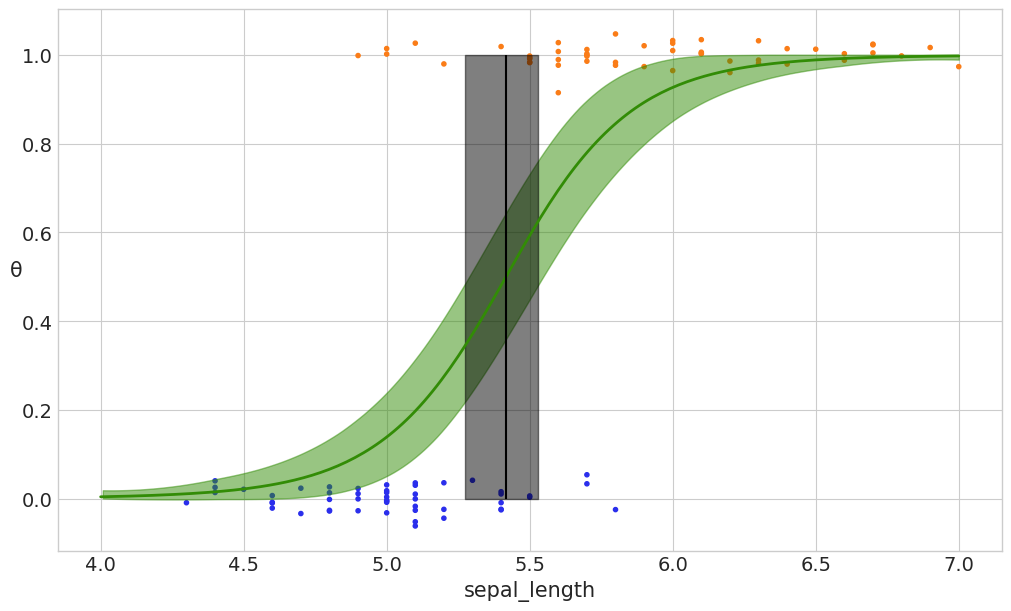

In [40]:
plot_sigmoid_db()
plt.show()

### GP Classification with a More Complex Target

One input feature, binary target, but:

This problem requires more than one decision boundary

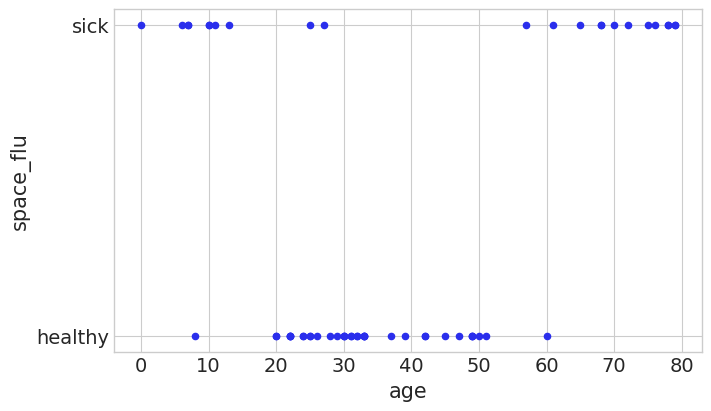

In [66]:
# Load the Space Flu dataset
data = pd.read_csv('data/space_flu.csv')
x = data.age.values[:, None]
y = data.space_flu.values

# Plot the data points
data.plot.scatter('age', 'space_flu', figsize=(7, 4))
plt.yticks([0, 1], ['healthy', 'sick'])
plt.show()

A GP classification model is capable of solving this problem.
The reason behind this is that, differently from a simpler logistic regression, a GP can also model non-linear functions.

In [67]:
# Build a PyMC3 GP classification model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter, and the GP prior
    ls = pm.HalfCauchy('ls', 1.0)
    cov = pm.gp.cov.ExpQuad(1, ls) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x)

    # Use logistic inverse link function and Bernoulli likelihood
    y_pred = pm.Bernoulli('y_pred', p=tt.nnet.sigmoid(f), observed=y)

In [68]:
# Sample from posterior
with model:
    trace = pm.sample(
        chains=2, draws=1000, tune=1000, cores=1,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, ls]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_1936\3646448333.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


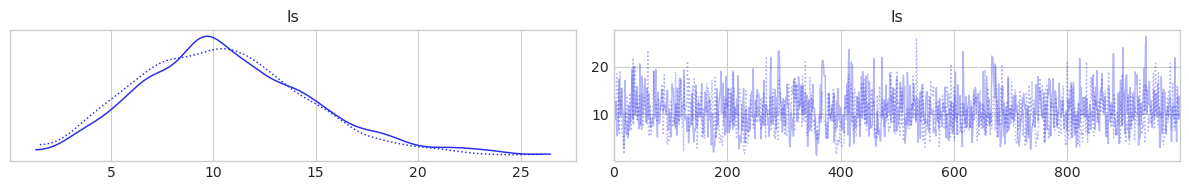

In [69]:
# Plot the traces
az.plot_trace(trace, var_names=['ls'])
plt.tight_layout()
plt.show()

Quite smooth functions with this $l$

Again, we can generate posterior predicitve samples and plot the results.

In [70]:
# Sample from the conditional distribution, over new un-observed points
x_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 200)[:, None]
with model:
    f_pred = gp.conditional('f_pred', x_new)
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['f_pred'], keep_size=True)
    pred_samples = pred_samples['f_pred'].squeeze() 

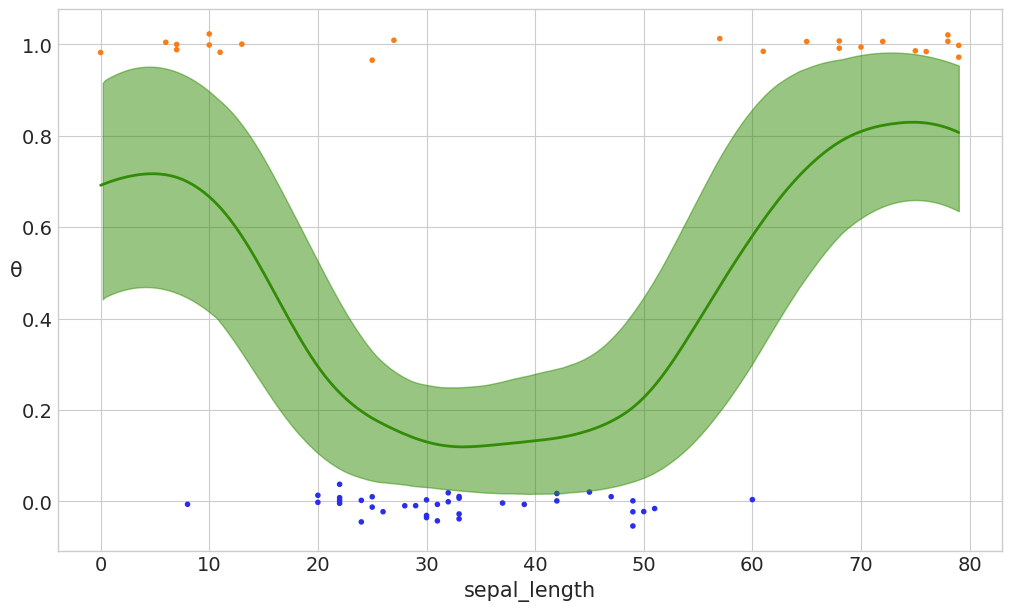

In [71]:
plot_sigmoid_db(plot_db=False)
plt.show()

# Regression with spatial autocorrelation

We have 10 island-societies and we want to model as **dependant variable**, the **number of tools** they use.
So we could use Poisson Regression.

We also have information on distances between islands

In [148]:
import pymc3 as pm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

In [82]:
islands_dist = pd.read_csv('data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [83]:
islands = pd.read_csv('data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


We have the **contact rate** column, but we'll use the distances as a proxy for it.

From this DataFrame, we are only going to use the columns
`total_tools`, `lat`, `lon2`, and `logpop`:

In [84]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

We are going to build the model:
$$
f \sim \mathcal{GP}([0, \dots, 0], K(d, d')) \\
\mu \sim exp(\alpha + \beta x + f) \\
y \sim Poisson(\mu)
$$
Here, we are omitting the priors for $\alpha$ and $\beta$, as well as the kernel's hyperpriors. $x$ is the log population, $d$ the island distances and $y$ is the total number of tools.

So this is a Poisson regression with a term that come from a GP. <br>
The distance matrix is used to compute the kernel of the GP, in order to model the number of tools as a function of the geographic similarity.

In [86]:
with pm.Model() as model_islands:
    eta = pm.HalfCauchy('eta', 1)
    l = pm.HalfCauchy('l', 1)

    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    mu = pm.math.exp(alpha + f[index] + beta * log_pop)
    tt_pred = pm.Poisson('tt_pred', mu, observed=total_tools)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\gp\cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [88]:
with model_islands:
    trace_islands = pm.sample(6000, tune=4000, target_accept=0.9, return_inferencedata=True,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, f_rotated_, l, eta]


Sampling 4 chains for 4_000 tune and 6_000 draw iterations (16_000 + 24_000 draws total) took 469 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Let's plot some samples from the posterior distribution:

In [146]:
def plot_dist_cov():
    trace_eta = trace_islands['posterior']['eta'].to_numpy()
    trace_eta = trace_eta.reshape(trace_eta.shape[0] * trace_eta.shape[1])
    trace_l = trace_islands['posterior']['l'].to_numpy()
    trace_l = trace_l.reshape(trace_l.shape[0] * trace_l.shape[1])
    _, ax = plt.subplots(1, 1, figsize=(8, 5))
    xrange = np.linspace(0, islands_dist.values.max(), 100)
    ax.plot(xrange, (trace_eta[::20][:, None] * np.exp(- trace_eta[::20][:, None] *
        xrange**2)).T, 'C0', alpha=.1, lw=0.5,)
    ax.plot(xrange, np.median(trace_eta) *
            np.exp(-np.median(trace_l) * xrange**2), lw=3, color='orange')

    ax.set_ylim(0, 1)
    ax.set_xlabel('distance (thousand kilometers)')
    ax.set_ylabel('covariance')
    plt.show()

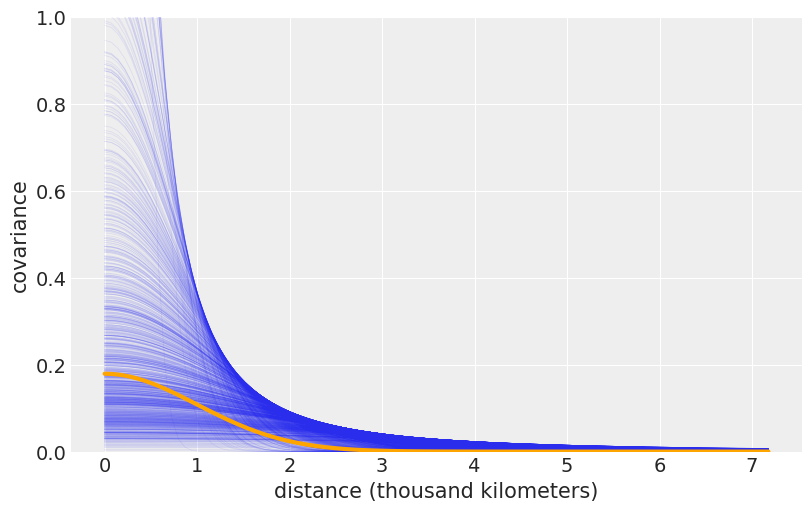

In [147]:
plot_dist_cov()

<font size=5>
The orange line is posterior median of the covariance between pairs of societies as a function of distance.
We use the median because the distribution for $\eta$ and $\mathcal{l}$ is very skewed.

    
- Covariance is not that high and also drops to almost 0 at about 2,000 kilometers.
- We can see that there is a lot of uncertainty (thin lines).

How strong the islands-societies are correlated among them according to our model?
We'll build the correlation matrix from the covariance matrix

In [153]:
def compute_corr():
    # compute posterior median covariance among societies
    trace_eta = trace_islands['posterior']['eta'].to_numpy()
    trace_eta = trace_eta.reshape(trace_eta.shape[0] * trace_eta.shape[1])
    trace_l = trace_islands['posterior']['l'].to_numpy()
    trace_l = trace_l.reshape(trace_l.shape[0] * trace_l.shape[1])
    sigma = np.median(trace_eta) * (np.exp(-np.median(trace_l) * islands_dist_sqr))
    # convert to correlation matrix
    sigma_post = np.diag(np.diag(sigma)**-0.5)
    ro = sigma_post @ sigma @ sigma_post
    ro = pd.DataFrame(ro, index=islands_dist.columns, columns=islands_dist.columns)
    sns.heatmap(ro.round(2), annot=True)
    plt.plot()

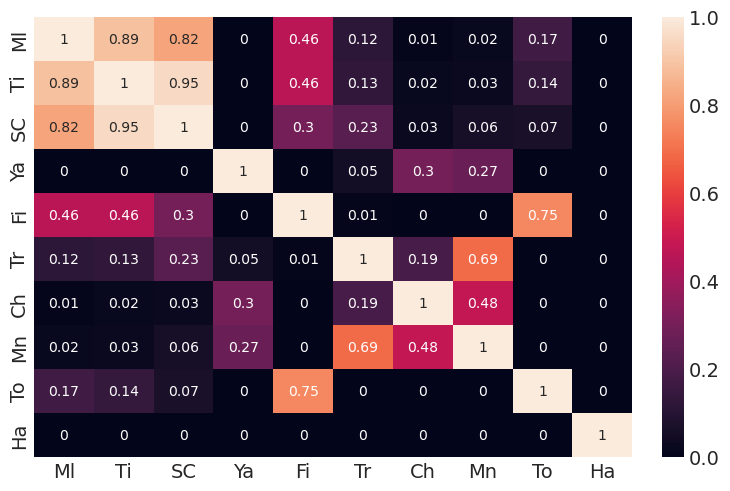

In [154]:
compute_corr()

- Hawaii is very lonely
    - Hawaii is very far away from the rest of the islands-societies.
- Malekula (Ml), Tikopia (Ti), and Santa Cruz (SC), are highly correlated with one another.
    - These societies are very close together, and they also have a similar number of tools.

In [10]:
def plot_societies():
    # scale point size to logpop
    logpop = np.copy(log_pop)
    logpop /= logpop.max()
    psize = np.exp(logpop*5.5)
    log_pop_seq = np.linspace(6, 14, 100)
    lambda_post = np.exp(trace_islands['alpha'][:, None] +
                         trace_islands['beta'][:, None] * log_pop_seq)

    _, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
    ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

    for i, itext in enumerate(culture_labels):
        ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
        ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


    ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

    az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
                plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


    for i in range(10):
        for j in np.arange(i+1, 10):
            ax[0].plot((islands.lon2[i], islands.lon2[j]),
                       (islands.lat[i], islands.lat[j]), 'C1-',
                       alpha=ro.iloc[i, j]**2, lw=4)
            ax[1].plot((islands.logpop[i], islands.logpop[j]),
                       (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                       alpha=ro.iloc[i, j]**2, lw=4)
    ax[0].set_xlabel('longitude')
    ax[0].set_ylabel('latitude')


    ax[1].set_xlabel('log-population')
    ax[1].set_ylabel('total tools')
    ax[1].set_xlim(6.8, 12.8)
    ax[1].set_ylim(10, 73)
    plt.show()

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


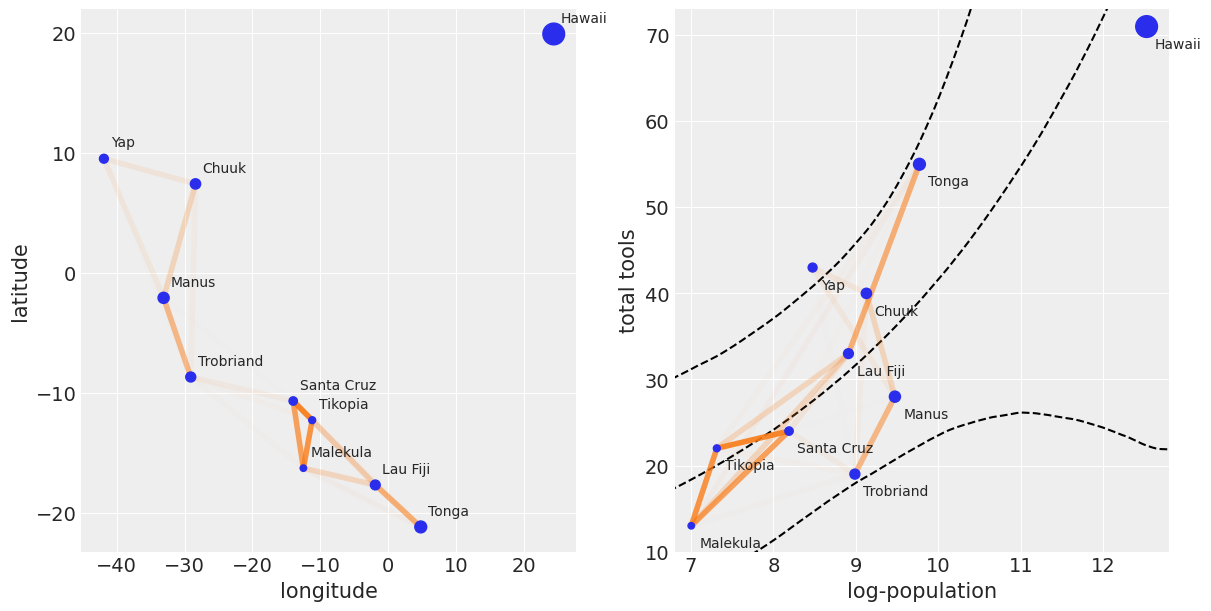

In [11]:
plot_societies()

Orange lines are the computed correlations

Some considerations are:
- Malekula, Tikopia, and Santa Cruz:
    - Have a rather low number of tools close to the median or lower than the expected number of tools for their populations
- Same with Trobriands and Manus:
    - geographically close and have fewer tools than expected for their population sizes
- Tonga has way more tools than expected for its population, and is close to Lau Fiji:
    - Model is telling us Tonga has a positive effect on Lau Fiji and counteracting effect of Malekula, Tikopia and Santa Cruz

# Poisson Process (and Cox Process)

Similar to GPs, a Poisson Process is a collection of random variables, where every _finite collection_ of those random variables is modeled by a multivariate Poisson distribution.

When the rate $\lambda$ of the Poisson process is itself a _stochastic process_, such as a GP, then we have what is known as **Cox Process**.

Just like Poisson distributions, a Cox Process is useful in modeling count data, as we see in the following practical example.

In [72]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import theano.tensor as tt

The _Coal-Mining Disasters_ datasets consists of years of coal-mining disasters in the UK from 1851 to 1962.
The number of disasters is thought to have been affected by changes in safety regulations during this period.

We want to model the rate of distasters per year as a function of time.

In [74]:
# Load the coal disasters dataset
data = pd.read_csv('data/coal.csv', header=None)

# Discretize the data
years = int(data.max().values - data.min().values)
bins = years // 4
hist, x_edges = np.histogram(data, bins=bins)

# Compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2.0

# Instantiate the preprocessed data
# The target express the rate number of disaster per year
x = x_centers[:, None]
y = hist / 4

The model we are going to use to fit the data is a Cox Process, i.e. a Poisson Process whose (logarithmic of) _rate_ parameter is modeled by a GP.
The _covariance function_ of the GP is defined on the years in our case.

$$\log \lambda \sim \mathcal{GP}(\mu_x, K(x,x'))$$
$$y \sim \mathcal{Poi}(\lambda)$$

In [75]:
# Build a PyMC3 Cox Process
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter, and the GP prior
    ls = pm.HalfNormal('ls', 32.0)
    cov = pm.gp.cov.ExpQuad(1, ls) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    log_rate = gp.prior('log_rate', X=x)

    # Use exponential inverse link function and Poisson likelihood
    y_pred = pm.Poisson('y_pred', mu=tt.exp(log_rate), observed=y)

In [76]:
# Sample from posterior
with model:
    trace = pm.sample(
        chains=1, draws=1000, tune=1000, cores=1,
        return_inferencedata=True,
        compute_convergence_checks=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [log_rate_rotated_, ls]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 18 seconds.


C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_1936\3646448333.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


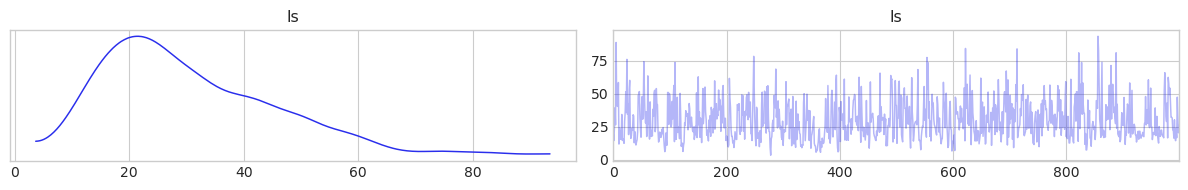

In [77]:
# Plot the traces
az.plot_trace(trace, var_names=['ls'])
plt.tight_layout()
plt.show()

We can now plot the results using the posterior distributions of the rate parameter.

In [79]:
def hdi50_94_plot():
    plt.figure(figsize=(10, 6))
    rate_trace = np.exp(np.asarray(trace['posterior']['log_rate']))
    rate_median = np.median(rate_trace.squeeze(0), axis=0)
    plt.plot(x_centers, rate_median, 'w', lw=2)
    az.plot_hdi(x_centers, rate_trace)
    az.plot_hdi(x_centers, rate_trace, hdi_prob=0.5, plot_kwargs={'alpha': 0})
    plt.plot(data.values, np.zeros_like(data.values) - 0.5, 'k|')
    plt.xlabel('years')
    plt.ylabel('rate')
    plt.show()

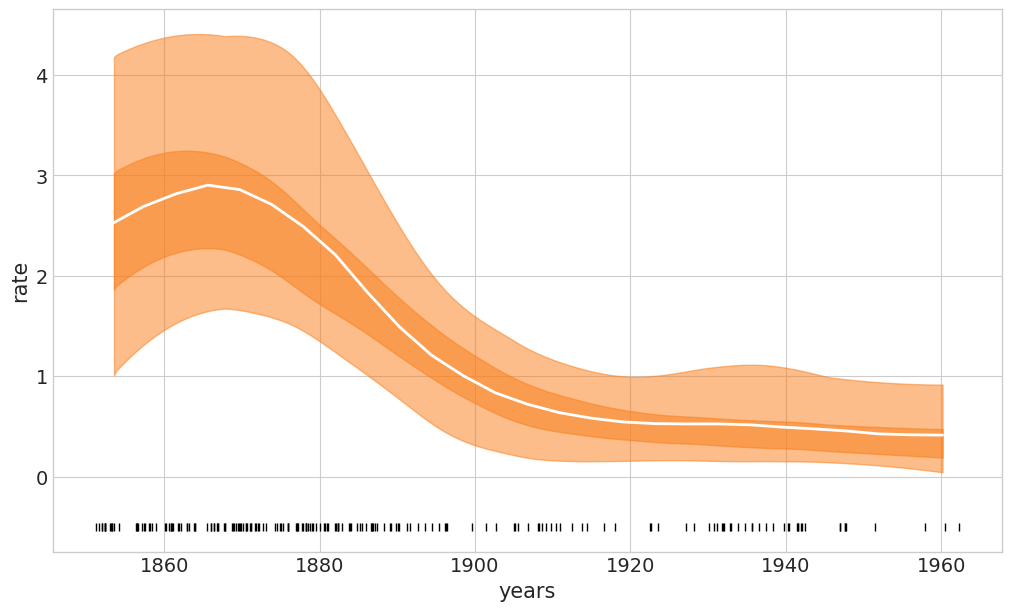

In [80]:
hdi50_94_plot()